In [20]:
# Import statements
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import acf
import epyestim.covid19 as c19
from epyestim.distributions import discretise_gamma
import multiprocessing as mp
import itertools

In [21]:
# Function to normalise EWS for 2-sigma calculations
def pandas_zscore(dataframe):
    rolling_mean = dataframe.expanding().mean()
    rolling_std = dataframe.expanding().std(ddof=0)
    normalise_stats = (dataframe - rolling_mean)/rolling_std
    return normalise_stats

# Function to calculate EWS on a rolling window for each column
def calculate_ews_rolling(wide_data, window_size):
    ews_data = {}
    acf_data = {}
    rolling = wide_data.rolling(window=window_size,center=False, min_periods=1)
    # variance = (wide_data**2).rolling(window=window_size,center=False, min_periods=1).mean()
    variance = rolling.var()
    coefficient_of_variation = rolling.std() / rolling.mean()
    iod = rolling.var() / rolling.mean()
    skew = rolling.skew()
    kurt = rolling.kurt()
    first_diff = rolling.var().diff(axis=0)
    ews_data['variance'] = variance
    ews_data['cov'] = coefficient_of_variation
    ews_data['skew'] = skew
    ews_data['kurt'] = kurt
    ews_data['iod'] = iod
    ews_data['first diff'] = first_diff
    for col in wide_data.columns:
        rolled_group = wide_data[col].rolling(window=window_size, min_periods=1)
        autocorrelation = rolled_group.apply(lambda x: acf(x, nlags=1)[1] if len(x) > 1 else np.nan)
        acf_data[col] = autocorrelation
    ews_data['acf'] = pd.DataFrame.from_dict(acf_data)
    normalised_ews_data = {}
    for ews in ews_data.keys():
        normalised_ews_data[ews] = pandas_zscore(ews_data[ews])
    return ews_data, normalised_ews_data

In [22]:
wide_data_total = pd.read_csv('Data/wide_total.csv')
wide_data_total['date'] = pd.to_datetime(wide_data_total['date'])
wide_data_total.set_index('date',inplace=True)
weekly_counts_total = pd.read_csv('Data/weekly_total.csv')
weekly_counts_total['date'] = pd.to_datetime(weekly_counts_total['date'])
weekly_counts_total.set_index('date',inplace=True)
cases = pd.read_csv('Data/cases_total.csv')
cases['date'] = pd.to_datetime(cases['date'])
cases.set_index('date',inplace=True)
npis = pd.read_csv('Data/ltla_to_nhs.csv')

In [23]:
# Get signals short windows
ews_7total, norm_ews_7total = calculate_ews_rolling(wide_data_total,window_size=7)
ews_14total, norm_ews_14total = calculate_ews_rolling(wide_data_total,window_size=14)

In [24]:
def long_run_averages(standardised):
    n = len(standardised)
    running_mean = np.zeros(n)
    running_std= np.zeros(n)
    for j in range(n):
        running_mean[j] = np.nanmean(standardised[1:j+1])
        running_std[j] = np.nanstd(standardised[1:j+1])
    return running_std, running_mean

def exceed_threshold_cutoffs(stat_timeseries, transition_dates, ltla):
    std_val = []
    mean_val = []
    prev_date = pd.Timestamp.min
    for date in transition_dates:
        current_timeseries = stat_timeseries[(stat_timeseries['date'] > prev_date) & (stat_timeseries['date'] <= date)]
        running_std, running_mean = long_run_averages(current_timeseries[ltla].values)
        std_val = np.concatenate((std_val,running_std))
        mean_val = np.concatenate((mean_val,running_mean))
        prev_date = date
    # Get indices where stat > mean + 2*sigma and indices where stat < mean - 2*sigma
    stat_timeseries = stat_timeseries[ltla].values
    indices_greater = [ n for n,i in enumerate(range(len(stat_timeseries))) if (stat_timeseries[i])>(mean_val+2*std_val)[i] ]
    indices_smaller =  [ n for n,i in enumerate(range(len(stat_timeseries))) if (stat_timeseries[i])<(mean_val-2*std_val)[i] ]
    all_indices = np.setdiff1d(np.unique(indices_greater + indices_smaller ),[1])    
    return all_indices,mean_val,std_val
    
def loop_EWSs_store_results_cutoffs(ews_dict, ltlas, ltla_transitions):
    indices_dict = {}
    mean_dict = {}
    std_dict = {}
    for stat in ews_dict.keys():
        indices_dict[stat] = {}
        mean_dict[stat] = {}
        std_dict[stat] = {}
        for ltla in ltlas:
            transition_dates = ltla_transitions[ltla]
            stat_data = ews_dict[stat][ltla].reset_index()
            indices, mean_val, std_val = exceed_threshold_cutoffs(stat_data, transition_dates, ltla)
            indices_dict[stat][ltla] = indices
            mean_dict[stat][ltla] = mean_val
            std_dict[stat][ltla] = std_val
    return indices_dict, mean_dict, std_dict

In [253]:
# areas = np.unique(cases['area_name'].values)
def find_critical_transitions(timeseries):
    fitted_r = c19.r_covid(timeseries,smoothing_window=63,gt_distribution=discretise_gamma(8.5,0.62))
    crossing_days = []
    values = fitted_r['R_mean'].values
    dates = fitted_r.reset_index()['index'].values
    # Loop through the values to find transitions through 1
    for i in range(len(values) - 1):
        if (values[i] < 1 and values[i+1] > 1) or (values[i] > 1 and values[i+1] < 1):
            crossing_days.append(dates[i+1])
    crossing_days.append(pd.Timestamp.max)
    return crossing_days

def do_finding(area):
    timeseries = cases[cases['area_name']==area]['value']
    return area, find_critical_transitions(timeseries)

# areas = ['Maidstone','Camden','York','Adur','Bradford','Crawley','Croydon','Dudley','East Hampshire','Worthing','West Lancashire','West Oxfordshire','Wigan','Wirral','Wyre','East Devon','East Lindsey']
areas = np.unique(ews_14total['variance'].columns.values)

with mp.Pool(6) as pool:
    results = pool.map(do_finding, areas)


ltla_transitions = {result[0]: result[1] for result in results}

import pickle 
with open('Data/ltla_transitions.pkl', 'wb') as f:
    pickle.dump(ltla_transitions, f)

# ltla_transitions = {}
# for area in areas:
#     timeseries = cases[cases['area_name']==area]['value']
#     ltla_transitions[area] = find_critical_transitions(timeseries)

In [6]:
import pickle        
with open('Data/ltla_transitions.pkl', 'rb') as f:
    ltla_transitions = pickle.load(f)

In [7]:
ews_dict = norm_ews_7total
areas = np.unique(ews_14total['variance'].columns.values)
ltlas = ['Maidstone','Camden','York']
areas = ltlas
two_sigma_cutoff, mean_dict, std_dict = loop_EWSs_store_results_cutoffs(ews_dict, areas, ltla_transitions)

/tmp/ipykernel_71772/56531340.py:6: RuntimeWarning: Mean of empty slice
  running_mean[j] = np.nanmean(standardised[1:j+1])
/home/jlooker/anaconda3/envs/mathsysbase/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_71772/56531340.py:6: RuntimeWarning: Mean of empty slice
  running_mean[j] = np.nanmean(standardised[1:j+1])
/home/jlooker/anaconda3/envs/mathsysbase/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_71772/56531340.py:6: RuntimeWarning: Mean of empty slice
  running_mean[j] = np.nanmean(standardised[1:j+1])
/home/jlooker/anaconda3/envs/mathsysbase/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out

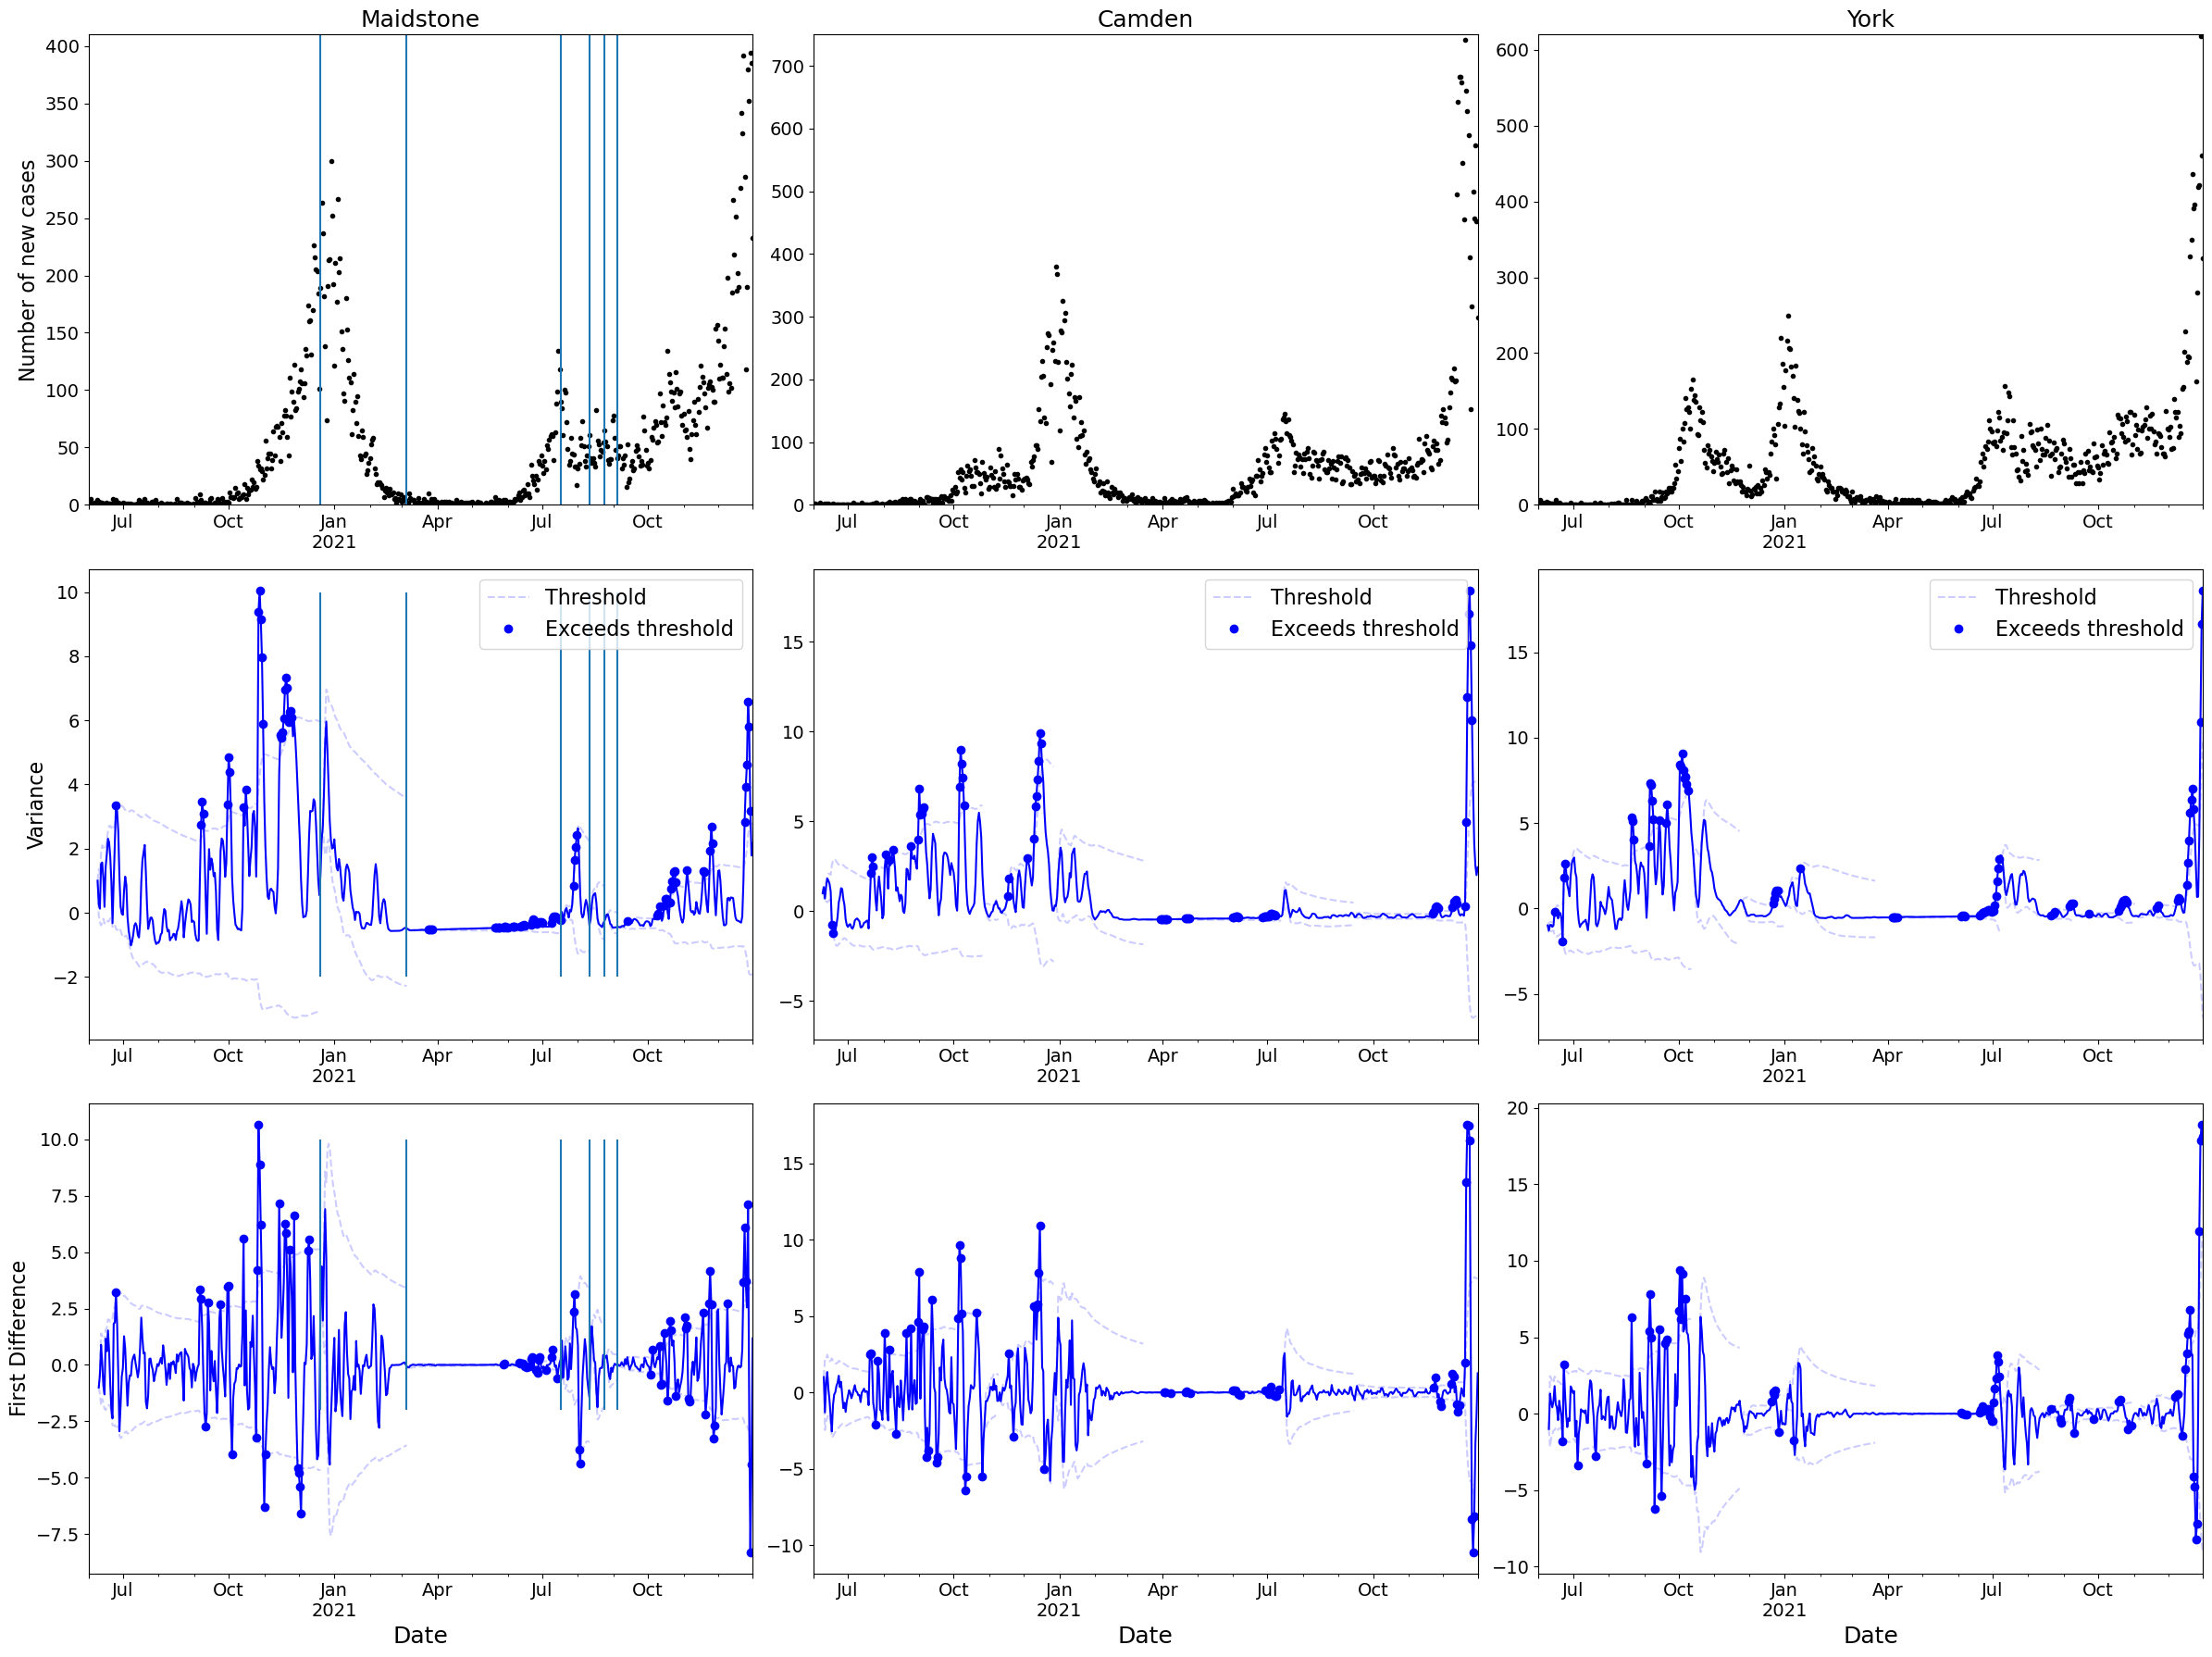

In [257]:
stats = ['variance', 'first diff']
labs = ['Variance','First Difference']
fig, axs = plt.subplots(nrows=len(stats)+1,ncols=3,figsize=(24,18))
cases[cases['area_name']=='Maidstone'].plot(y='value',style='.',ax=axs[0,0],color='black',legend='False')
axs[0,0].set_ylim((0,410))
axs[0,0].set_title('Maidstone',fontsize=18)
axs[0,0].vlines(x=ltla_transitions['Maidstone'][:-1],ymin=0,ymax=410)
cases[cases['area_name']=='Camden'].plot(y='value',style='.',ax=axs[0,1],color='black',legend='False')
axs[0,1].set_title('Camden',fontsize=18)
axs[0,1].set_ylim((0,750))
cases[cases['area_name']=='York'].plot(y='value',style='.',ax=axs[0,2],color='black',legend='False')
axs[0,2].set_title('York',fontsize=18)
axs[0,2].set_ylim((0,620))
axs[0,0].set_ylabel('Number of new cases',fontsize=16)
for i in range(3):
    axs[0,i].xaxis.label.set_visible(False)
    axs[0,i].tick_params(axis='x', labelsize=14)
    axs[0,i].tick_params(axis='y', labelsize=14)
    axs[0,i].get_legend().remove()

for i, stat in enumerate(stats):
    stat_data = norm_ews_7total[stat]
    y_data = stat_data['Maidstone'].copy(deep=True)
    std_val = std_dict[stat]['Maidstone']
    mean_val = mean_dict[stat]['Maidstone']
    y_data.plot(ax=axs[i+1,0],color='blue',label='')
    y_data = y_data.reset_index()
    y_data['Top'] = mean_val + 2*std_val
    y_data['Bottom'] = mean_val - 2*std_val
    y_data.set_index('date')
    y_data.plot(ax=axs[i+1,0],x='date',y='Top',color='blue',alpha=0.2,style='--',label='Threshold')
    y_data.plot(ax=axs[i+1,0],x='date',y='Bottom',color='blue',alpha=0.2,style='--',label='')
    y_data = y_data.iloc[two_sigma_cutoff[stat]['Maidstone']].drop(columns=['Top','Bottom']).set_index('date')
    y_data.plot(ax=axs[i+1,0],y='Maidstone',color='blue',style='o',label='Exceeds threshold')
    if (stat == "variance"):
        axs[i+1,0].legend(fontsize=16)
    else:
        axs[i+1,0].get_legend().set_visible(False)
    axs[i+1,0].set_ylabel(stat)
    axs[i+1,0].xaxis.label.set_visible(False)
    axs[i+1,0].tick_params(axis='x', labelsize=14)
    axs[i+1,0].tick_params(axis='y', labelsize=14)
    axs[i+1,0].vlines(x=ltla_transitions['Maidstone'][:-1],ymin=-2,ymax=10)
for i, stat in enumerate(stats):
    stat_data = norm_ews_7total[stat]
    std_val = std_dict[stat]['Camden']
    mean_val = mean_dict[stat]['Camden']
    y_data = stat_data['Camden']
    y_data.plot(ax=axs[i+1,1],color='blue',label='')
    y_data = y_data.reset_index()
    y_data['Top'] = mean_val + 2*std_val
    y_data['Bottom'] = mean_val - 2*std_val
    y_data.set_index('date')
    y_data.plot(ax=axs[i+1,1],x='date',y='Top',color='blue',alpha=0.2,style='--',label='Threshold')
    y_data.plot(ax=axs[i+1,1],x='date',y='Bottom',color='blue',alpha=0.2,style='--',label='')
    y_data = y_data.iloc[two_sigma_cutoff[stat]['Camden']].drop(columns=['Top','Bottom']).set_index('date')
    y_data.plot(ax=axs[i+1,1],y='Camden',color='blue',style='o',label='Exceeds threshold')
    if (stat == "variance"):
        axs[i+1,1].legend(fontsize=16)
    else:
        axs[i+1,1].get_legend().set_visible(False)
    axs[i+1,1].xaxis.label.set_visible(False)
    axs[i+1,1].tick_params(axis='x', labelsize=14)
    axs[i+1,1].tick_params(axis='y', labelsize=14)
for i, stat in enumerate(stats):
    stat_data = norm_ews_7total[stat]
    std_val = std_dict[stat]['York']
    mean_val = mean_dict[stat]['York']
    y_data = stat_data['York']
    y_data.plot(ax=axs[i+1,2],color='blue',label='')
    y_data = y_data.reset_index()
    y_data['Top'] = mean_val + 2*std_val
    y_data['Bottom'] = mean_val - 2*std_val
    y_data.set_index('date')
    y_data.plot(ax=axs[i+1,2],x='date',y='Top',color='blue',alpha=0.2,style='--',label='Threshold')
    y_data.plot(ax=axs[i+1,2],x='date',y='Bottom',color='blue',alpha=0.2,style='--',label='')
    y_data = y_data.iloc[two_sigma_cutoff[stat]['York']].drop(columns=['Top','Bottom']).set_index('date')
    y_data.plot(ax=axs[i+1,2],y='York',color='blue',style='o',label='Exceeds threshold')
    if (stat == "variance"):
        axs[i+1,2].legend(fontsize=16)
    else:
        axs[i+1,2].get_legend().set_visible(False)
    axs[i+1,2].xaxis.label.set_visible(False)
    axs[i+1,2].tick_params(axis='x', labelsize=14)
    axs[i+1,2].tick_params(axis='y', labelsize=14)

for i in range(3):
    axs[len(axs)-1,i].set_xlabel("Date",fontsize=18)
    axs[len(axs)-1,i].xaxis.label.set_visible(True)

for i in range(1,3):
    axs[i,0].set_ylabel(labs[i-1],fontsize=16)
fig.tight_layout()
# plt.savefig("Figures/spatialrolling2sigmacutoff.pdf",dpi=2400,bbox_inches='tight')
plt.show()

In [8]:
# Get detect indices for timeline
from operator import itemgetter

def detect(arr):
    if len(arr) < 3:
        return []

    values = []
    i = 0
    while i < len(arr) - 2:
        if arr[i] + 1 == arr[i + 1] and arr[i + 1] + 1 == arr[i + 2]:
            values.append(arr[i + 2])
            # Skip to the end of this sequence of consecutive numbers
            while i + 2 < len(arr) - 1 and arr[i + 2] + 1 == arr[i + 3]:
                i += 1
        i += 1
    
    return values

In [9]:
detect_var = {}
detect_fd = {}

for area in areas:
    detect_var[area] = detect(two_sigma_cutoff['variance'][area])
    detect_fd[area] = detect(two_sigma_cutoff['first diff'][area])

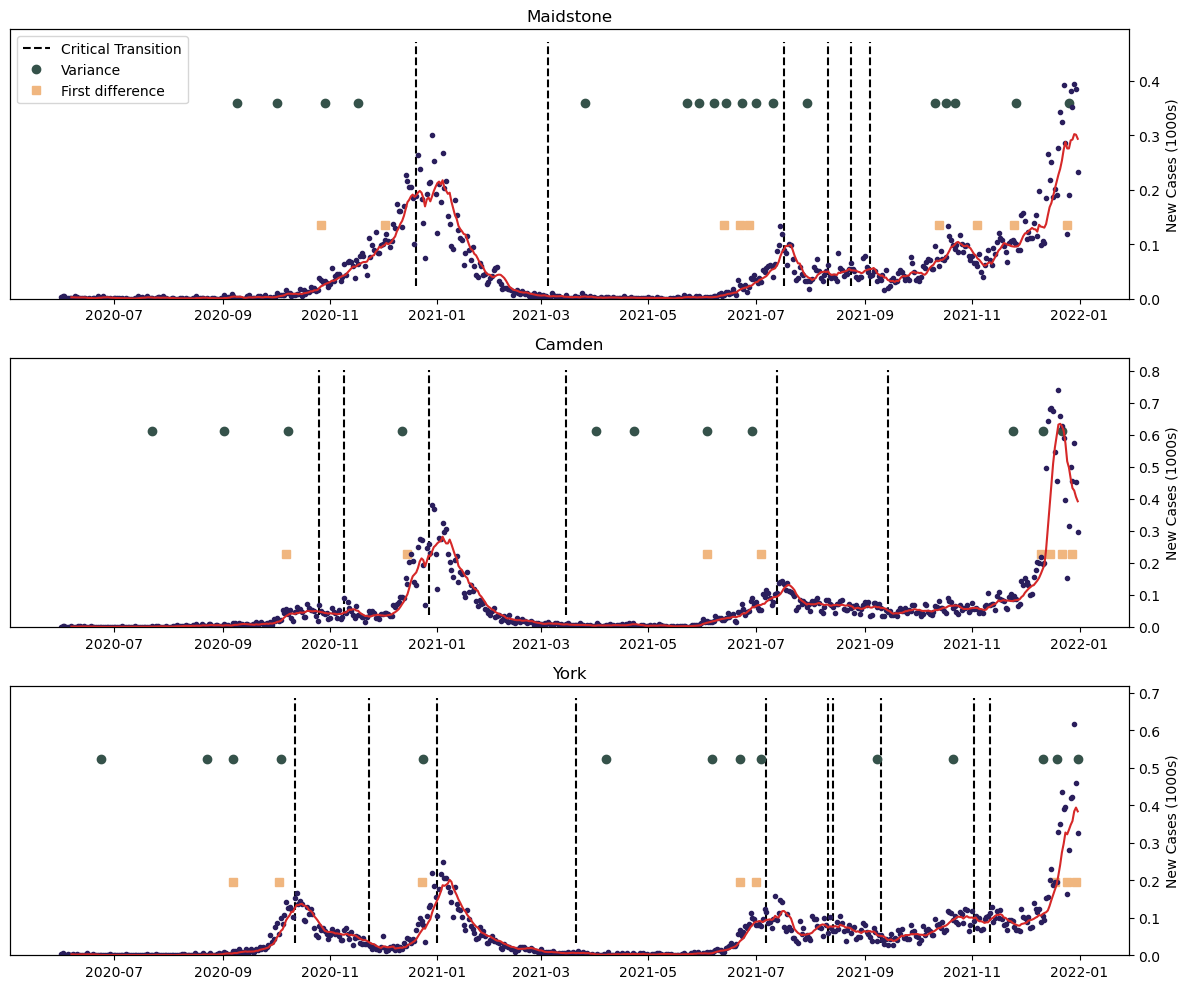

In [15]:
fig, axs = plt.subplots(3,1,figsize=(12,10))
for i, region in enumerate(ltlas):
    axs[i].vlines(x=ltla_transitions[region][:-1],ymin=-1,ymax=1,color='k',label='Critical Transition',linestyle='--')    
    signal_data = norm_ews_7total['variance'][region]
    signal_data = signal_data.reset_index()
    xs = signal_data['date'][detect_var[region]]
    axs[i].plot(xs,[0.5]*len(xs),'o',color='#35524A',label='Variance')

    signal_data = norm_ews_7total['first diff'][region]
    signal_data = signal_data.reset_index()
    xs = signal_data['date'][detect_fd[region]]
    axs[i].plot(xs,[-0.5]*len(xs),'s',color='#F0B67F',label='First difference')

    ax = axs[i].twinx()
    counts =  cases[cases['area_name']==region].reset_index()
    counts['value'] = counts['value'] / 1000
    counts['rolling'] = counts['value'].rolling(7).mean()
    ax.plot(counts['date'],counts['value'],".",label="UKHSA data",color='#2A1E5C')
    ax.plot(counts['date'],counts['rolling'],label="7 day rolling mean",color='#D62828')
    ax.set_ylim([0,np.max(counts['value'].values)+0.1])
    axs[i].set_title(region)
    # ax.get_yaxis().set_ticks([])
    axs[i].get_yaxis().set_ticks([])
    ax.set_ylabel('New Cases (1000s)')

axs[0].legend()
plt.tight_layout()
plt.savefig('Figures/ltla_timeline.pdf')
plt.show()

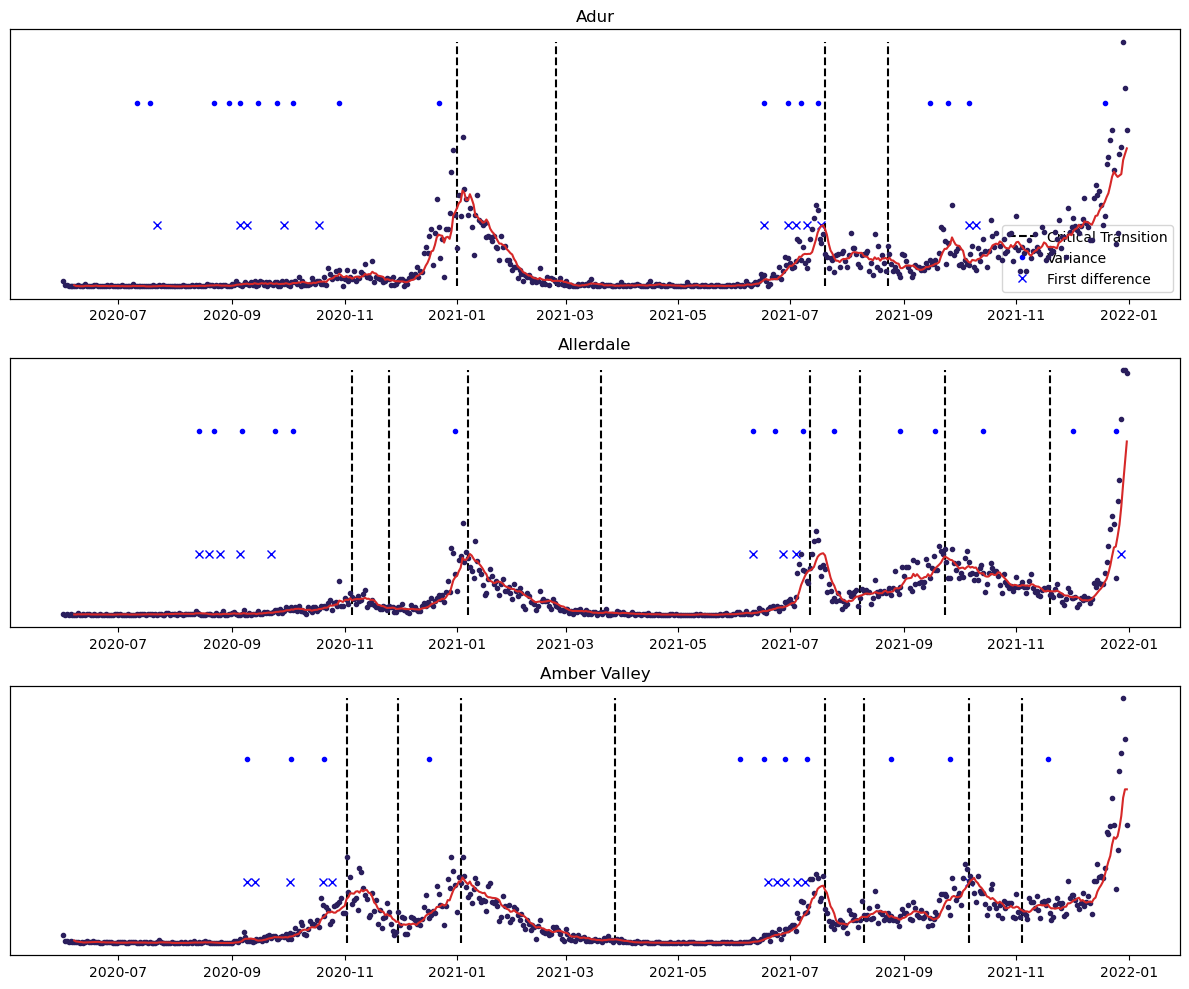

In [262]:
ltlas_test = ['Adur','Allerdale','Amber Valley']
fig, axs = plt.subplots(len(ltlas_test),1,figsize=(12,3.333*len(ltlas_test)))
for i, region in enumerate(ltlas_test):
    axs[i].vlines(x=ltla_transitions[region][:-1],ymin=-1,ymax=1,color='k',label='Critical Transition',linestyle='--')    
    signal_data = norm_ews_7total['variance'][region]
    signal_data = signal_data.reset_index()
    xs = signal_data['date'][detect_var[region]]
    axs[i].plot(xs,[0.5]*len(xs),'.',color='blue',label='Variance')

    signal_data = norm_ews_7total['first diff'][region]
    signal_data = signal_data.reset_index()
    xs = signal_data['date'][detect_fd[region]]
    axs[i].plot(xs,[-0.5]*len(xs),'x',color='blue',label='First difference')

    ax = axs[i].twinx()
    counts =  cases[cases['area_name']==region]
    counts = counts.reset_index()
    counts['rolling'] = counts['value'].rolling(7).mean()
    ax.plot(counts['date'],counts['value'],".",label="UKHSA data",color='#2A1E5C')
    ax.plot(counts['date'],counts['rolling'],label="7 day rolling mean",color='#D62828')
    ax.set_ylim()
    axs[i].set_title(region)
    ax.get_yaxis().set_ticks([])
    axs[i].get_yaxis().set_ticks([])

axs[0].legend()
plt.tight_layout()
plt.show()

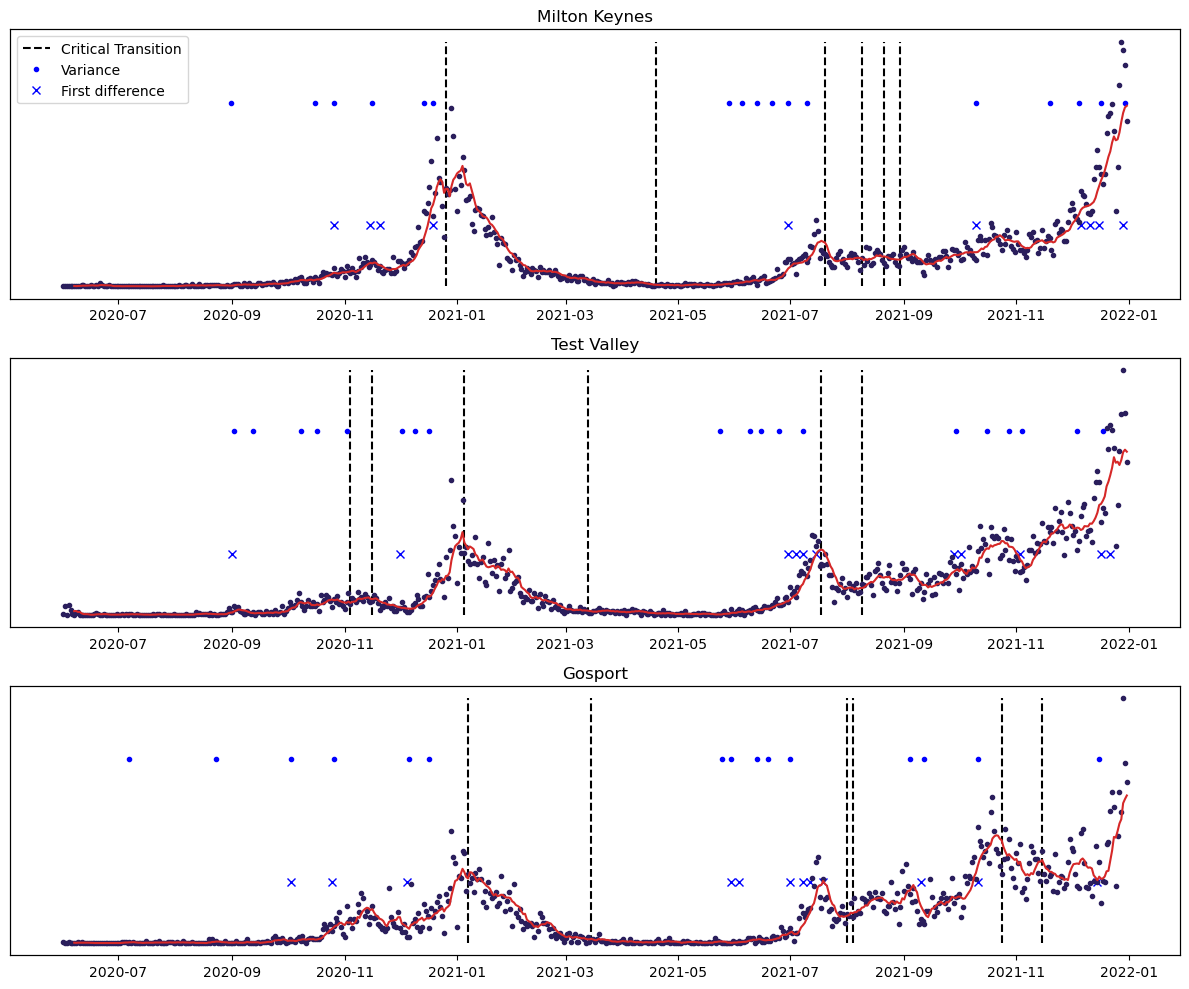

In [68]:
ltlas_test = ['Milton Keynes','Test Valley','Gosport']
fig, axs = plt.subplots(len(ltlas_test),1,figsize=(12,3.333*len(ltlas_test)))
for i, region in enumerate(ltlas_test):
    axs[i].vlines(x=ltla_transitions[region][:-1],ymin=-1,ymax=1,color='k',label='Critical Transition',linestyle='--')    
    signal_data = norm_ews_7total['variance'][region]
    signal_data = signal_data.reset_index()
    xs = signal_data['date'][detect_var[region]]
    axs[i].plot(xs,[0.5]*len(xs),'.',color='blue',label='Variance')

    signal_data = norm_ews_7total['first diff'][region]
    signal_data = signal_data.reset_index()
    xs = signal_data['date'][detect_fd[region]]
    axs[i].plot(xs,[-0.5]*len(xs),'x',color='blue',label='First difference')

    ax = axs[i].twinx()
    counts =  cases[cases['area_name']==region]
    counts = counts.reset_index()
    counts['rolling'] = counts['value'].rolling(7).mean()
    ax.plot(counts['date'],counts['value'],".",label="UKHSA data",color='#2A1E5C')
    ax.plot(counts['date'],counts['rolling'],label="7 day rolling mean",color='#D62828')
    ax.set_ylim()
    axs[i].set_title(region)
    ax.get_yaxis().set_ticks([])
    axs[i].get_yaxis().set_ticks([])

axs[0].legend()
plt.tight_layout()
plt.show()

In [10]:
def closest_date(dates, reference_date = pd.Timestamp('2021-01-01'), start_date = pd.Timestamp('2020-10-29'), end_date = pd.Timestamp('2021-02-01')):
    # Filter dates within the specified range
    filtered_dates = [date for date in dates if start_date < date < end_date]

    # Check if there are any dates in the filtered list
    if not filtered_dates:
        return None

    # Find the date closest to the reference date
    closest_date = min(filtered_dates, key=lambda date: abs(date - reference_date))

    return closest_date

december_transitions = {key: closest_date(ltla_transitions[key]) for key in ltla_transitions.keys()}

In [11]:
def find_dates(transitions, tr, ant, start_date = pd.Timestamp('2020-10-25')):
    # Ensure the reference date is a pandas Timestamp
    tr = pd.Timestamp(tr)
    # Convert all dates in transitions and ant to pandas Timestamps
    transitions = [pd.Timestamp(date) for date in transitions]
    ant = [pd.Timestamp(date) for date in ant]
    # Filter transitions to keep only those before the reference date
    transitions_before_tr = [date for date in transitions if date < tr]
    # Find the date closest to but before the reference date
    if not transitions_before_tr:
        last_trans = pd.Timestamp.min
    else:
        last_trans = max(transitions_before_tr)
    # Filter ant to keep only those after the last transition date and after start_date
    ant_after_last_trans = [date for date in ant if date > last_trans]
    ant_after_last_trans = [date for date in ant_after_last_trans if date > start_date]

    # If there are no dates after the last transition date, return max time and np.na
    if not ant_after_last_trans:
        return [pd.Timestamp.max, np.nan]
    # Find the earliest available date in ant after last_trans
    ant_date = min(ant_after_last_trans)
    return [ant_date, (tr - ant_date).days]

dec_trans_dates_var = {area: find_dates(ltla_transitions[area], december_transitions[area], norm_ews_7total['variance'][area].reset_index()['date'][detect_var[area]]) for area in areas}

In [30]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

gdf = gpd.read_file('Local_Authority_Districts_(December_2020)_UK_BUC_simplified-shp')
gdf = gdf[gdf.LAD20CD.str.startswith('E')]
gdf_ltlas = np.unique(gdf.LAD20NM.values)
print('GDF only:',gdf_ltlas[~np.isin(gdf_ltlas,areas)])
print('Cases only:',areas[~np.isin(areas,gdf_ltlas)])

GDF only: ['Buckinghamshire' 'City of London' 'Cornwall' 'Hackney' 'Isles of Scilly']
Cases only: ['Aylesbury Vale' 'Chiltern' 'Cornwall and Isles of Scilly'
 'Hackney and City of London' 'South Bucks' 'Wycombe']


In [31]:
dec_trans_dates_var['Buckinghamshire'] = dec_trans_dates_var['South Bucks']
dec_trans_dates_var['City of London'] = dec_trans_dates_var['Hackney and City of London']
dec_trans_dates_var['Hackney'] = dec_trans_dates_var['Hackney and City of London']
dec_trans_dates_var['Isles of Scilly'] = dec_trans_dates_var['Cornwall and Isles of Scilly']
dec_trans_dates_var['Cornwall'] = dec_trans_dates_var['Cornwall and Isles of Scilly']

In [32]:
dec_df = pd.DataFrame.from_dict(dec_trans_dates_var).T.reset_index()
dec_df.columns = ['LAD20NM','Date','Ant']
dec_df['Ant'] = pd.to_numeric(dec_df.Ant)
gdf = gdf.merge(dec_df, on='LAD20NM')
gdf['Days'] = np.where(gdf['Ant'] < 0, 0, gdf['Ant'])

In [ ]:
days_df = gdf.copy(deep=True)
fig, ax = plt.subplots(1, 1, figsize=(8, 12))
cmap = plt.cm.viridis
days_df.plot(column='Days', ax=ax, legend=True, cmap = cmap,
         legend_kwds={'label': "Days from critical transition",
                      'orientation': "horizontal",
                      'ticks': [0,10,30,50,70]})
ax.get_yaxis().set_ticks([])
ax.get_xaxis().set_ticks([])
colorbar = ax.get_figure().axes[1]
colorbar.set_xticklabels(['No detection', 10, 30, 50, 70], fontsize = 12)
colorbar.set_xlabel("Days from critical transition", fontsize=14)
plt.tight_layout()
plt.savefig('Figures/LTLAmap.pdf')
plt.show()

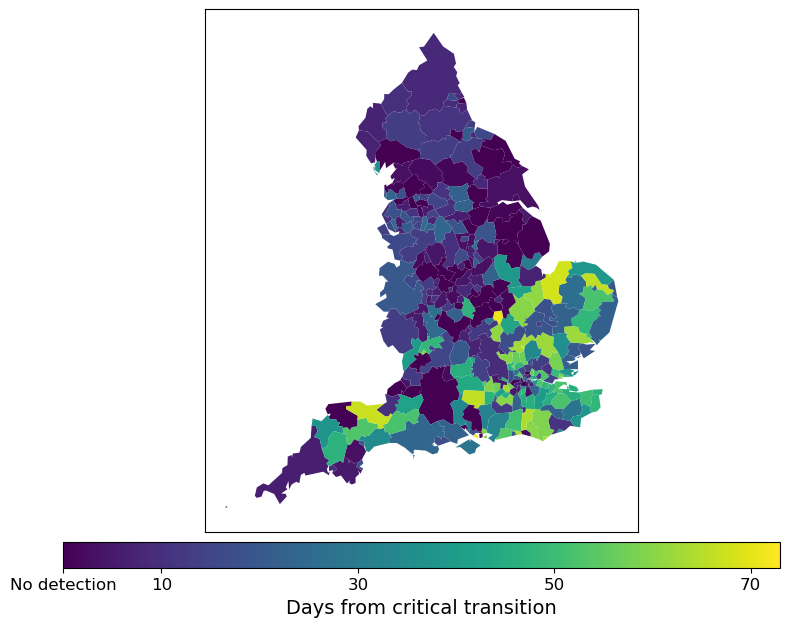

In [42]:
days_df = gdf.copy(deep=True)
fig, ax = plt.subplots(1, 1, figsize=(8, 12))
cmap = plt.cm.viridis
norm = plt.Normalize(vmin=0, vmax=max(days_df['Days']))
days_df.plot(column='Days', ax=ax, cmap = cmap, norm=norm)

ax.get_yaxis().set_ticks([])
ax.get_xaxis().set_ticks([])

divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.1)

sm = plt.cm.ScalarMappable(cmap=cmap,norm=norm)
sm._A = []
cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')
cbar.set_ticks([0,10,30,50,70])
cbar.set_ticklabels(['No detection', 10, 30, 50, 70], fontsize = 12)

cbar.set_label("Days from critical transition", fontsize=14)
plt.tight_layout()
plt.savefig('Figures/LTLAmap.pdf')
plt.show()

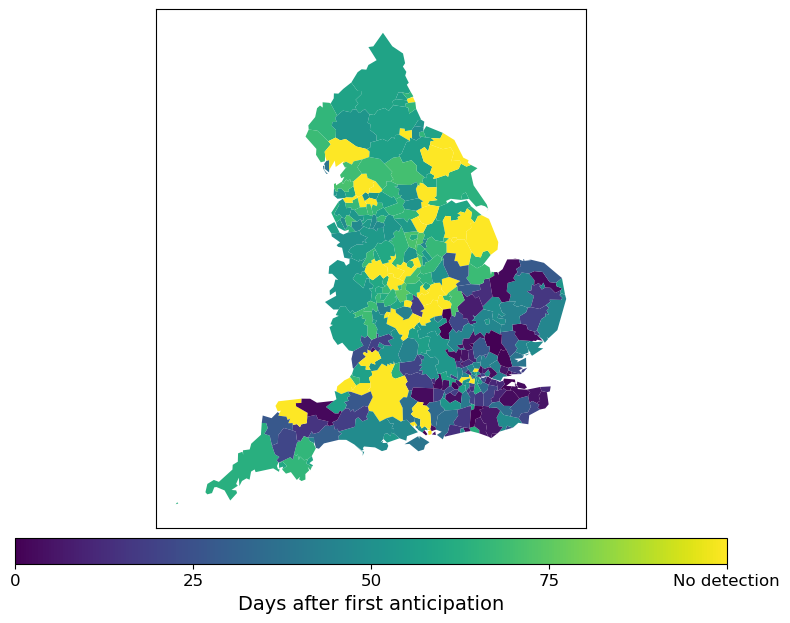

In [44]:
gdf['minDate'] = [(value - min(gdf['Date'])).days for value in gdf['Date'].values]
gdf['minDate'] = np.where(gdf['Ant'] < 0, 100, gdf['minDate'])
date_df = gdf.copy(deep=True)
fig, ax = plt.subplots(1, 1, figsize=(8, 12))
cmap = plt.cm.viridis
norm = plt.Normalize(vmin=0, vmax=max(date_df['minDate']))
date_df.plot(column='minDate', ax=ax, cmap = cmap, norm=norm)
ax.get_yaxis().set_ticks([])
ax.get_xaxis().set_ticks([])

divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.1)

sm = plt.cm.ScalarMappable(cmap=cmap,norm=norm)
sm._A = []
cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')
cbar.set_ticks([0, 25, 50, 75, 100])
cbar.set_ticklabels([0, 25, 50, 75, 'No detection'], fontsize = 12)

cbar.set_label("Days after first anticipation", fontsize=14)
plt.tight_layout()
plt.savefig('Figures/LTLAmapdate.pdf')
plt.show()

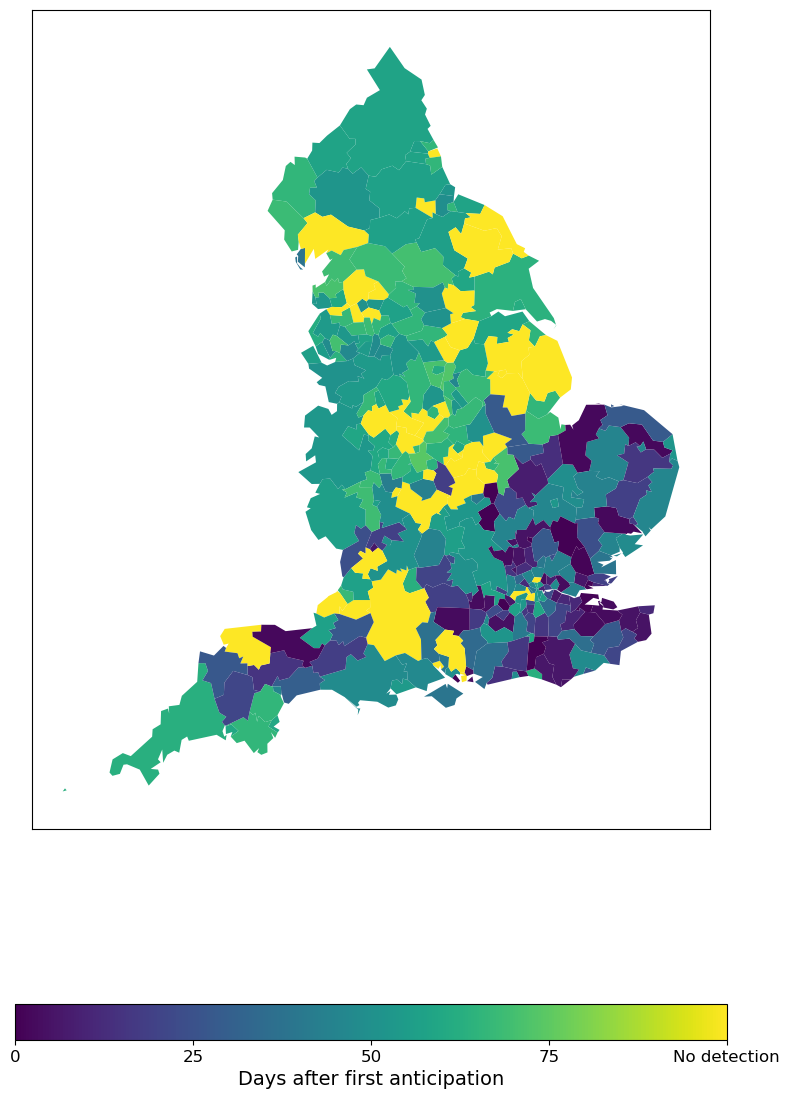

In [26]:
gdf['minDate'] = [(value - min(gdf['Date'])).days for value in gdf['Date'].values]
gdf['minDate'] = np.where(gdf['Ant'] < 0, 100, gdf['minDate'])
date_df = gdf.copy(deep=True)
fig, ax = plt.subplots(1, 1, figsize=(8, 12))
date_df.plot(column='minDate', ax=ax, legend=True,
         legend_kwds={'label': "Days after first anticipation",
                      'orientation': "horizontal",
                      'ticks': [0, 25, 50, 75, 100]})
ax.get_yaxis().set_ticks([])
ax.get_xaxis().set_ticks([])
colorbar = ax.get_figure().axes[1]
colorbar.set_xticklabels([0, 25, 50, 75, 'No detection'],fontsize = 12)
colorbar.set_xlabel("Days after first anticipation", fontsize=14)
plt.tight_layout()
plt.savefig('Figures/LTLAmapdate.pdf')
plt.show()

/tmp/ipykernel_61783/1993153893.py:8: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


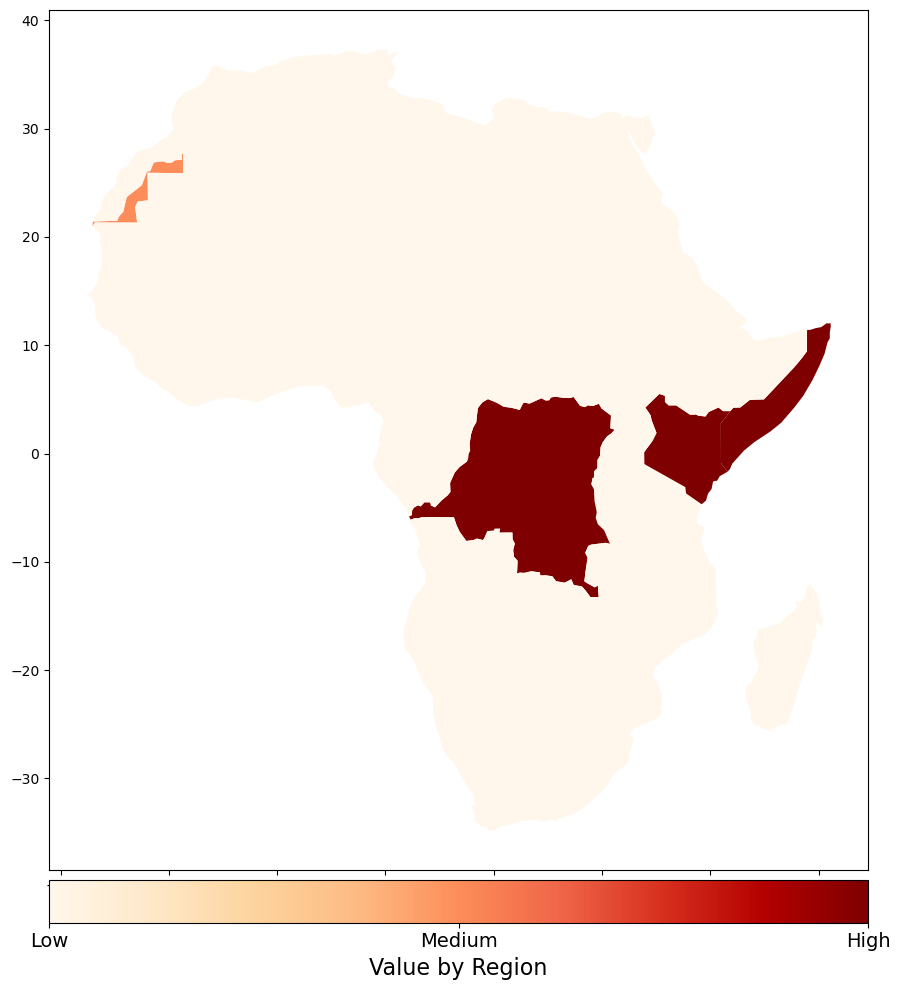

In [29]:
# Step 1: Load example GeoDataFrame (using the built-in 'naturalearth_lowres' dataset from GeoPandas)
gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Focus on a few countries and add a 'region_id' for merging
gdf = gdf[gdf['continent'] == 'Africa'].reset_index(drop=True)
gdf['region_id'] = gdf.index + 1  # Creating a 'region_id' column

# Step 2: Create a DataFrame of integers (simulating some values)
integer_data = {
    'region_id': gdf['region_id'],  # Using the same region_id as in gdf
    'value': [10, 20, 30, 40, 50] + [10] * (len(gdf) - 5)  # Example values, repeating to match gdf length
}
df = pd.DataFrame(integer_data)

# Step 3: Cap values at 30
df['value'] = np.where(df['value'] > 30, 30, df['value'])

# Step 4: Merge the DataFrame with the GeoDataFrame
gdf = gdf.merge(df, on='region_id')

# Step 5: Plot the map with areas shaded by the capped values
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
cmap = plt.cm.OrRd  # Choose a color map
norm = plt.Normalize(vmin=10, vmax=30)  # Normalize between 10 and 30

# Plotting the GeoDataFrame
gdf.plot(column='value', ax=ax, cmap=cmap, norm=norm)

# Step 6: Create a divider for the existing axis to place the colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.1)

# Step 7: Add the colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []  # Dummy mappable for the colorbar
cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')

# Step 8: Modify the tick labels to 'Low', 'Medium', and 'High' with increased font size
cbar.set_ticks([10, 20, 30])
cbar.set_ticklabels(['Low', 'Medium', 'High'])
cbar.ax.tick_params(labelsize=14)  # Set custom tick labels with font size

# Step 9: Increase the font size of the label itself
cbar.set_label("Value by Region", fontsize=16)  # Increase label size

# Adjust layout to reduce whitespace
plt.tight_layout()

plt.show()